# **Import Dataset and Libraries**

In [489]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

df = pd.read_csv("Desktop/UNCC/ML Project/Datasets/df4.csv", low_memory=False)
df.head()

,ZIP,LATITUDE_PUBLIC,LONGITUDE_PUBLIC,Year,Month,Day,DayOfWeek,CMPD_PATROL_DIVISION,LOCATION_TYPE_DESCRIPTION,PLACE_TYPE_DESCRIPTION,...,PctHome_Ownership,HighSchool,NonWhite,F65_,Poverty,Home_Ownership,Score,VulnerableBinary,Violent-Crime,People
0,28215.0,35.258195,-80.726229,2023,12,4,0,1,1,1,...,0.75,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0,63548.0
1,28213.0,35.283274,-80.762293,2023,12,4,0,2,1,2,...,0.76,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0,44553.0
2,28210.0,35.153683,-80.839845,2023,12,4,0,5,3,4,...,0.53,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0,48214.0
3,28215.0,35.248899,-80.667217,2023,10,23,0,1,2,4,...,0.74,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,63548.0
4,28227.0,35.221991,-80.814908,2023,12,4,0,6,1,4,...,0.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,58524.0


# **Pre-processing**

In [496]:
shuffled = shuffle(df, random_state=42)

training_data = shuffled[shuffled['Year'] != 2023]
validation_data = shuffled[shuffled['Year'] == 2023]

y_train = training_data.pop('Violent-Crime').values
y_test = validation_data.pop('Violent-Crime').values

X_train = StandardScaler().fit_transform(training_data)
X_test = StandardScaler().fit_transform(validation_data)

(271794, 25)

# **Model Declaration and Instantiation**

In [491]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the model
class SpatiotemporalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpatiotemporalModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, 32, kernel_size=1)
        self.lstm = nn.LSTM(32, 50, batch_first=True)
        self.fc = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a channel dimension for Conv1d
        x = F.relu(self.conv1d(x))
        x, _ = self.lstm(x.permute(0, 2, 1))  # LSTM expects input in (batch, seq_len, features) format
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = 1
model = SpatiotemporalModel(input_size, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.unsqueeze(1)  # Add an extra dimension to match the output size
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        predicted_labels = (torch.sigmoid(y_pred) > 0.5).float().numpy()
        val_accuracy = accuracy_score(y_test, predicted_labels)
    
    end_time = time.time()
    epoch_time = end_time - start_time

    # Print epoch information
    print(f"Epoch {epoch + 1}/{epochs}, Time: {epoch_time:.2f}s, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10, Time: 29.60s, Validation Accuracy: 0.9014
Epoch 2/10, Time: 27.02s, Validation Accuracy: 0.9776
Epoch 3/10, Time: 23.30s, Validation Accuracy: 0.9383
Epoch 4/10, Time: 24.00s, Validation Accuracy: 0.9176
Epoch 5/10, Time: 24.95s, Validation Accuracy: 0.9795
Epoch 6/10, Time: 22.79s, Validation Accuracy: 0.9685
Epoch 7/10, Time: 23.95s, Validation Accuracy: 0.9800
Epoch 8/10, Time: 26.50s, Validation Accuracy: 0.9765
Epoch 9/10, Time: 21.41s, Validation Accuracy: 0.9850
Epoch 10/10, Time: 22.25s, Validation Accuracy: 0.9786


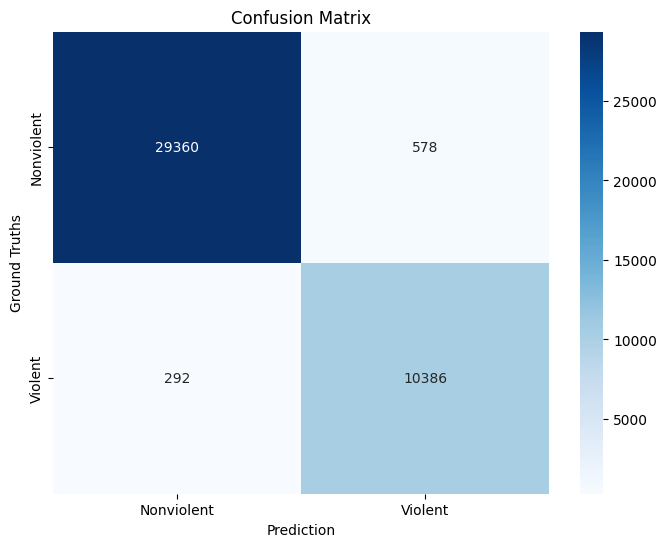

In [494]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Nonviolent', 'Violent'], yticklabels=['Nonviolent', 'Violent'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truths')
plt.title('Confusion Matrix')
plt.show()

# **Data Visualization**

Mapping

In [493]:
# coordinates = df.iloc[:1000, 1:3].values

# minLatitude = df.iloc[:, 1].min()
# maxLatitude = df.iloc[:, 1].max()

# minLongitude = df.iloc[:, 2].min()
# maxLongitude = df.iloc[:, 2].max()

# centerLatitude = (minLatitude + maxLatitude) / 2
# centerLongitude = (minLongitude + maxLongitude) / 2

# charlotte_map = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=10)

# for coord in coordinates:
#     folium.Marker(location=coord, popup=str(coord)).add_to(charlotte_map)
# charlotte_map